In [7]:
import json
from pathlib import Path
import os
import nibabel as nib
import numpy as np 
import nrrd
import re
from typing import Tuple
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
from os.path import join
from utils.helper import convert_file_format, make_if_dont_exist,convert_file_format
import torch

# File arrangement

- Take the seg.nrrd ones to GT_TRAINING_LABELS_PATH and leave GT_TRAINING_DATASET_PATH empty until "NRRD to NIFTI (fixing label matches)" title
- Copy volume 0000.nii.gz to TRAINING_DATASET_PATH

In [2]:
import os

folder_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/extra_data/file_arrangements"

for file_name in os.listdir(folder_path):
    old_path = os.path.join(folder_path, file_name)
    
    if file_name.endswith("masked.nrrd"):
        parts = file_name.split("_")
        if len(parts) >= 2:
            new_name = f"{parts[0]}_{parts[1]}_0000.nrrd"
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {file_name} -> {new_name}")

    elif file_name.endswith("seg.nrrd"):
        if file_name.endswith("left.seg.nrrd"):
            parts = file_name.split("_")
            if len(parts) >= 1:
                new_name = f"{parts[0]}_RCL5_left.seg.nrrd"
                new_path = os.path.join(folder_path, new_name)
                os.rename(old_path, new_path)
                print(f"Renamed: {file_name} -> {new_name}")
        elif file_name.endswith("right.seg.nrrd"):
            parts = file_name.split("_")
            if len(parts) >= 1:
                new_name = f"{parts[0]}0_RCL5_right.seg.nrrd"
                new_path = os.path.join(folder_path, new_name)
                os.rename(old_path, new_path)
                print(f"Renamed: {file_name} -> {new_name}")
        else:
            parts = file_name.split("_")
            if len(parts) >= 1:
                new_name = f"{parts[0]}_RCL5.seg.nrrd"
                new_path = os.path.join(folder_path, new_name)
                os.rename(old_path, new_path)
                print(f"Renamed: {file_name} -> {new_name}")
        
            
    elif file_name.endswith("masked_left.nrrd"):
        parts = file_name.split("_")
        if len(parts) >= 2:
            new_name = f"{parts[0]}_{parts[1]}_left_0000.nrrd"
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {file_name} -> {new_name}")
            

            
    elif file_name.endswith("masked_right.nrrd"):
        parts = file_name.split("_")
        if len(parts) >= 2:
            new_name = f"{parts[0]}0_{parts[1]}_right_0000.nrrd"
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {file_name} -> {new_name}")
            

    


Renamed: NG2561_RCL5_masked_left.nrrd -> NG2561_RCL5_left_0000.nrrd
Renamed: NG2561_RCL5_masked_right.nrrd -> NG25610_RCL5_right_0000.nrrd
Renamed: NG2561_Segments_left.seg.nrrd -> NG2561_RCL5_left.seg.nrrd
Renamed: NG2561_Segments_right.seg.nrrd -> NG25610_RCL5_right.seg.nrrd
Renamed: NG2562_RCL5_masked_left.nrrd -> NG2562_RCL5_left_0000.nrrd
Renamed: NG2562_Segments_left.seg.nrrd -> NG2562_RCL5_left.seg.nrrd
Renamed: NG2565_Segments.seg.nrrd -> NG2565_RCL5.seg.nrrd
Renamed: NG4997_RCL5_masked.nrrd -> NG4997_RCL5_0000.nrrd
Renamed: NG4997_Segments.seg.nrrd -> NG4997_RCL5.seg.nrrd


# Convert NRRD to NIFTI

In [5]:
convert_file_format(folder_path, folder_path, '.nrrd')

File convert done. 


# Path arrangements

In [2]:
# define dataset path
BASE_PATH = Path('./').resolve()
DATA_PATH = BASE_PATH / 'dataset'

project_name = 'first'  # Change here for different task names
task_name = 'Dataset004_' + project_name

TRAINING_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'imagesTr'
GT_TRAINING_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'labelsTr'  # Only nii.gz labels
GT_TRAINING_LABELS_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / 'extracting_labels'  # Store .nrrd label maps separately
TEST_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'imagesTs'

PREDICTION_RESULTS_PATH = BASE_PATH / 'dataset/nnUNet_Prediction_Results' / task_name
TASK_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name

# setup environment variables
nnUNet_raw = BASE_PATH / 'dataset/nnUNet_raw_data'
nnUNet_preprocessed = BASE_PATH / 'dataset/nnUNet_preprocessed'
nnUNet_results = BASE_PATH / 'dataset/nnUNet_results'

In [ ]:
make_if_dont_exist(TRAINING_DATASET_PATH,overwrite=False)
make_if_dont_exist(GT_TRAINING_DATASET_PATH)
make_if_dont_exist(TEST_DATASET_PATH)

make_if_dont_exist(PREDICTION_RESULTS_PATH)

make_if_dont_exist(nnUNet_preprocessed)
make_if_dont_exist(nnUNet_results)

In [3]:
train_files = os.listdir(TRAINING_DATASET_PATH)
label_files = os.listdir(GT_TRAINING_DATASET_PATH)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))


train image files: 16
train label files: 16
Matches: 0


# Check metadata

In [8]:


file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/extra_data/file_arrangements/NG2561_RCL5_left.seg.nrrd"
data, header = nrrd.read(file_path)

# Convert data to tensor
tensor_data = torch.tensor(data, dtype=torch.float32)
unique_labels = torch.unique(tensor_data)

# Print all metadata
print("NRRD Metadata:")
for key, value in header.items():
    print(f"{key}: {value}")

# Extract label names
label_names = {key.split('_')[0]: value for key, value in header.items() if key.endswith("_Name")}

# Extract corresponding intensity values from LabelValue
intensity_levels = {
    key.split('_')[0]: value for key, value in header.items() if key.endswith("_")
}

# Ensure intensity values are numeric and map them to labels
label_intensity_mapping = {
    label_names[key]: int(intensity_levels[key])
    for key in label_names if key in intensity_levels and str(intensity_levels[key]).isdigit()
}

print(f"{file_path}:", label_intensity_mapping)


NRRD Metadata:
type: unsigned char
dimension: 3
space: left-posterior-superior
sizes: [317 734 401]
space directions: [[-0.0144355  0.         0.       ]
 [ 0.        -0.0144355  0.       ]
 [ 0.         0.         0.0144355]]
kinds: ['domain', 'domain', 'domain']
encoding: gzip
space origin: [ 8.22974968 -0.0950494   1.78751004]
Segment0_Color: 0.854902 1 1
Segment0_ColorAutoGenerated: 1
Segment0_Extent: 0 316 0 733 0 400
Segment0_ID: Segment_1
Segment0_LabelValue: 1
Segment0_Layer: 0
Segment0_Name: mask
Segment0_NameAutoGenerated: 1
Segment0_Tags: Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^91720002^Body Substance~SCT^74947009^Gas~^^~Anatomic codes - DICOM master list~^^~^^|
Segment10_Color: 0.564706 0.933333 0.564706
Segment10_ColorAutoGenerated: 1
Segment10_Extent: 0 316 0 733 0 400
Segment10_ID: Segment_11
Segment10_LabelValue: 11
Segment10_Layer: 0
Segment10_Name: f
Segment10_NameAutoGenerated: 1
Segment10_Ta

In [13]:
file=file_path
if file.endswith("seg.nrrd"):
    file_path = os.path.join(folder_path, file)
    data, header = nrrd.read(file_path)

    # Extract label names
    label_names = {key.split('_')[0]: value for key, value in header.items() if key.endswith("_Name")}
    
    # Process and extract numbers
    for key, value in label_names.items():
        match = re.match(r"Segment(\d+)", key)  # Extract digits after "Segment"
        if match:
            segment_number = match.group(1)  # Extracted number as string
            print(f"'{value}' : {segment_number},", end=" ")


'mask' : 0, 'f' : 10, 'st' : 11, 'ic' : 12, 'och' : 13, 'ac' : 14, 'fr' : 15, 'Hb' : 16, 'TH' : 17, 'MB' : 18, 'HY' : 19, 'CTX+' : 1, 'P' : 20, 'MY' : 21, 'Cerebellum_AV' : 22, 'Cerebellum_GL' : 23, 'Cerebellum_ML' : 24, 'V' : 25, 'OB' : 26, 'border' : 27, 'cc+' : 2, 'CPu' : 3, 'DG' : 4, 'HP' : 5, 'RHP' : 6, 'A' : 7, 'ig' : 8, 'fi' : 9, 

# Check labels

In [5]:


folder_path = GT_TRAINING_LABELS_PATH
output_csv = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/segment_labels.csv"  # Output CSV file name

# Open the CSV file for writing
with open(output_csv, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write the header row
    csv_writer.writerow(["Filename", "Segment Number", "Label Name"])
    
    # Loop through the folder and process seg.nrrd files
    for file in os.listdir(folder_path):
        if file.endswith("seg.nrrd"):
            file_path = os.path.join(folder_path, file)
            data, header = nrrd.read(file_path)

            # Extract label names
            label_names = {key.split('_')[0]: value for key, value in header.items() if key.endswith("_Name")}
            
            # Process and extract numbers
            for key, value in label_names.items():
                match = re.match(r"Segment(\d+)", key)  # Extract digits after "Segment"
                if match:
                    segment_number = match.group(1)  # Extracted number as string
                    csv_writer.writerow([file, segment_number, value])  # Write to CSV

print(f"CSV file '{output_csv}' has been created successfully!")


CSV file '/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/segment_labels.csv' has been created successfully!


In [4]:


# Function to save JSON
def save_json(data, file_path, sort_keys=False):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4, sort_keys=sort_keys)
def generate_dataset_json(output_folder: str,
                          channel_names: dict,
                          labels: dict,
                          num_training_cases: int,
                          file_ending: str,
                          regions_class_order: Tuple[int, ...] = None,
                          dataset_name: str = None, reference: str = None, release: str = None, license: str = None,
                          description: str = None,
                          overwrite_image_reader_writer: str = None, **kwargs):
    
    has_regions: bool = any([isinstance(i, (tuple, list)) and len(i) > 1 for i in labels.values()])
    if has_regions:
        assert regions_class_order is not None, f"You have defined regions but regions_class_order is not set. " \
                                                f"You need that."
    # channel names need strings as keys
    keys = list(channel_names.keys())
    for k in keys:
        if not isinstance(k, str):
            channel_names[str(k)] = channel_names[k]
            del channel_names[k]

    # labels need ints as values
    for l in labels.keys():
        value = labels[l]
        if isinstance(value, (tuple, list)):
            value = tuple([int(i) for i in value])
            labels[l] = value
        else:
            labels[l] = int(labels[l])

    dataset_json = {
        'channel_names': channel_names,  # previously this was called 'modality'. I didn't like this so this is
        # channel_names now. Live with it.
        'labels': labels,
        'numTraining': num_training_cases,
        'file_ending': file_ending,
    }

    if dataset_name is not None:
        dataset_json['name'] = dataset_name
    if reference is not None:
        dataset_json['reference'] = reference
    if release is not None:
        dataset_json['release'] = release
    if license is not None:
        dataset_json['licence'] = license
    if description is not None:
        dataset_json['description'] = description
    if overwrite_image_reader_writer is not None:
        dataset_json['overwrite_image_reader_writer'] = overwrite_image_reader_writer
    if regions_class_order is not None:
        dataset_json['regions_class_order'] = regions_class_order

    dataset_json.update(kwargs)

    save_json(dataset_json, join(output_folder, 'dataset.json'), sort_keys=False)
# Extract label names dynamically from .nrrd files in extracting_labels folder
def extract_labels_from_nrrd(folder_path):
    label_dict = {"background": 0}  # Ensure background is always labeled as 0

    for file in os.listdir(folder_path):
        if file.endswith(".seg.nrrd"):  # Process only segmentation nrrd files
            file_path = os.path.join(folder_path, file)
            data, header = nrrd.read(file_path)

            # Extract segment numbers and names
            for key, value in header.items():
                if key.endswith("_Name"):
                    match = re.match(r"Segment(\d+)", key)  # Extract segment number
                    if match:
                        segment_number = int(match.group(1))
                        if value.lower() != "mask":  # Exclude "mask"
                            label_dict[value] = segment_number  

    return label_dict

# Extract labels dynamically, ensuring "mask" is not included
labels = extract_labels_from_nrrd(GT_TRAINING_LABELS_PATH)
print(labels)

{'background': 0, 'f': 10, 'st': 11, 'ic': 12, 'och': 13, 'ac': 14, 'fr': 15, 'Hb': 16, 'TH': 17, 'MB': 18, 'HY': 19, 'CTX+': 1, 'P': 20, 'MY': 21, 'Cerebellum_AV': 22, 'Cerebellum_GL': 23, 'Cerebellum_ML': 24, 'V': 25, 'OB': 26, 'border': 27, 'cc+': 2, 'CPu': 3, 'DG': 4, 'HP': 5, 'RHP': 6, 'A': 7, 'ig': 8, 'fi': 9}


# NRRD to NIFTI (fixing label matches)

In [ ]:

# Predefined Label Mapping (Global Consistency Across Files)
LABEL_DICT = {
    'mask': 0, 'f': 10, 'st': 11, 'ic': 12, 'och': 13, 'ac': 14, 'fr': 15, 'Hb': 16, 'TH': 17, 'MB': 18,
    'HY': 19, 'CTX+': 1, 'P': 20, 'MY': 21, 'Cerebellum_AV': 22, 'Cerebellum_GL': 23, 'Cerebellum_ML': 24,
    'V': 25, 'OB': 26, 'border': 27, 'cc+': 2, 'CPu': 3, 'DG': 4, 'HP': 5, 'RHP': 6, 'A': 7, 'ig': 8, 'fi': 9
}

def convert_nrrd_to_nifti(nrrd_folder, output_folder, label_dict):
    """Convert NRRD segmentation files to NIfTI format using only label names (ignoring segment numbers)."""
    os.makedirs(output_folder, exist_ok=True)

    for file in os.listdir(nrrd_folder):
        if file.endswith(".seg.nrrd"):
            file_path = os.path.join(nrrd_folder, file)
            data, header = nrrd.read(file_path)

            # Initialize an empty segmentation map
            new_data = np.zeros_like(data, dtype=np.uint8)

            print(f"\n📂 Processing: {file}")  # Print filename being processed

            # Extract and apply label mappings
            for key, label_name in header.items():
                if key.endswith("_Name") and label_name in label_dict:
                    label_value = label_dict[label_name]

                    # Extract the corresponding segment number from its ID
                    segment_id_key = key.replace("_Name", "_ID")  # Example: Segment10_ID
                    if segment_id_key in header:
                        segment_id = header[segment_id_key]  # Example: "Segment_11"
                        segment_number = int(segment_id.split("_")[-1])  # Extract "11"

                        # Assign the correct label value wherever this name appears
                        new_data[data == segment_number] = label_value
                        print(f"🔹 Label: {label_name} → {label_value} (Segment ID: {segment_id})")  # Debugging info

            # Save as NIfTI
            nifti_img = nib.Nifti1Image(new_data, np.eye(4))  # Identity affine matrix
            nifti_filename = os.path.splitext(file)[0] + ".nii.gz"
            nifti_filepath = os.path.join(output_folder, nifti_filename)
            nib.save(nifti_img, nifti_filepath)
            print(f"✅ Saved NIfTI: {nifti_filepath}")

# Convert all NRRD files using only label names
convert_nrrd_to_nifti(GT_TRAINING_LABELS_PATH, GT_TRAINING_DATASET_PATH, LABEL_DICT)


# Create json file

In [8]:
# Function to save JSON
def save_json(data, file_path, sort_keys=False):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4, sort_keys=sort_keys)
def generate_dataset_json(output_folder: str,
                          channel_names: dict,
                          labels: dict,
                          num_training_cases: int,
                          file_ending: str,
                          regions_class_order: Tuple[int, ...] = None,
                          dataset_name: str = None, reference: str = None, release: str = None, license: str = None,
                          description: str = None,
                          overwrite_image_reader_writer: str = None, **kwargs):
    
    has_regions: bool = any([isinstance(i, (tuple, list)) and len(i) > 1 for i in labels.values()])
    if has_regions:
        assert regions_class_order is not None, f"You have defined regions but regions_class_order is not set. " \
                                                f"You need that."
    # channel names need strings as keys
    keys = list(channel_names.keys())
    for k in keys:
        if not isinstance(k, str):
            channel_names[str(k)] = channel_names[k]
            del channel_names[k]

    # labels need ints as values
    for l in labels.keys():
        value = labels[l]
        if isinstance(value, (tuple, list)):
            value = tuple([int(i) for i in value])
            labels[l] = value
        else:
            labels[l] = int(labels[l])

    dataset_json = {
        'channel_names': channel_names,  # previously this was called 'modality'. I didn't like this so this is
        # channel_names now. Live with it.
        'labels': labels,
        'numTraining': num_training_cases,
        'file_ending': file_ending,
    }

    if dataset_name is not None:
        dataset_json['name'] = dataset_name
    if reference is not None:
        dataset_json['reference'] = reference
    if release is not None:
        dataset_json['release'] = release
    if license is not None:
        dataset_json['licence'] = license
    if description is not None:
        dataset_json['description'] = description
    if overwrite_image_reader_writer is not None:
        dataset_json['overwrite_image_reader_writer'] = overwrite_image_reader_writer
    if regions_class_order is not None:
        dataset_json['regions_class_order'] = regions_class_order

    dataset_json.update(kwargs)

    save_json(dataset_json, join(output_folder, 'dataset.json'), sort_keys=False)
# Extract label names dynamically from .nrrd files in extracting_labels folder
def extract_labels_from_nrrd(folder_path):
    label_dict = {"background": 0}  # Ensure background is always labeled as 0

    for file in os.listdir(folder_path):
        if file.endswith(".seg.nrrd"):  # Process only segmentation nrrd files
            file_path = os.path.join(folder_path, file)
            data, header = nrrd.read(file_path)

            # Extract segment numbers and names
            for key, value in header.items():
                if key.endswith("_Name"):
                    match = re.match(r"Segment(\d+)", key)  # Extract segment number
                    if match:
                        segment_number = int(match.group(1))
                        if value.lower() != "mask":  # Exclude "mask"
                            label_dict[value] = segment_number  

    return label_dict

# Extract labels dynamically, ensuring "mask" is not included
labels = extract_labels_from_nrrd(GT_TRAINING_LABELS_PATH)

# List all nii.gz label files (ignore .nrrd files)
image_files = sorted(os.listdir(TRAINING_DATASET_PATH))
label_files = sorted(f for f in os.listdir(GT_TRAINING_DATASET_PATH) if f.endswith(".nii.gz"))
test_ids = sorted(os.listdir(TEST_DATASET_PATH))

channel_names = {"0": "microscopic"}
num_training_cases = len(image_files)
file_ending = ".nii.gz"

# Generate dataset.json dynamically
generate_dataset_json(
    output_folder=TASK_PATH,
    channel_names=channel_names,
    labels=labels,  # Now "mask" is excluded
    num_training_cases=num_training_cases,
    file_ending=file_ending,
    dataset_name="Mouse Brain Segmentation",
    description="Mouse Brain Segmentation",
    reference="",
    release="0.0",
    license="",
    training=[
        {'image': f"./imagesTr/{image_file}", 'label': f"./labelsTr/{label_file}"}
        for image_file, label_file in zip(image_files, label_files)
    ],
    test=["./imagesTs/%s" % (i[:i.find("_0000")] + '.nii.gz') for i in test_ids]
)


# Visualize

In [ ]:


# Define label dictionary with fixed colors
label_colors = {
    'mask': 'black', 'f': 'blue', 'st': 'cyan', 'ic': 'green', 'och': 'lime',
    'ac': 'red', 'fr': 'orange', 'Hb': 'pink', 'TH': 'purple', 'MB': 'brown',
    'HY': 'yellow', 'CTX+': 'magenta', 'P': 'gold', 'MY': 'lightblue',
    'Cerebellum_AV': 'gray', 'Cerebellum_GL': 'darkgray', 'Cerebellum_ML': 'lightgray',
    'V': 'darkblue', 'OB': 'olive', 'border': 'tan', 'cc+': 'darkred', 'CPu': 'teal',
    'DG': 'coral', 'HP': 'navy', 'RHP': 'maroon', 'A': 'violet', 'ig': 'chartreuse',
    'fi': 'turquoise'
}

# Convert label name to numerical mapping (if needed)
label_dict = {name: i for i, name in enumerate(label_colors.keys())}

# Create a color map from the dictionary
cmap = mcolors.ListedColormap([label_colors[label] for label in label_dict.keys()])
bounds = np.arange(len(label_dict) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

def plot_nifti_slices(nifti_file):
    """Visualize the NIfTI file from three different axes using a fixed colormap."""
    img = nib.load(nifti_file)
    data = img.get_fdata().astype(int)  # Convert to integer labels

    # Get dimensions
    x_size, y_size, z_size = data.shape

    # Compute half-slice indices
    mid_x = x_size // 2
    mid_y = y_size // 2
    mid_z = z_size // 2

    # Plot slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(data[mid_x, :, :].T, cmap=cmap, norm=norm, origin="lower")  # Sagittal (XZ)
    axes[0].set_title("Sagittal View (Mid X)")

    axes[1].imshow(data[:, mid_y, :].T, cmap=cmap, norm=norm, origin="lower")  # Coronal (YZ)
    axes[1].set_title("Coronal View (Mid Y)")

    axes[2].imshow(data[:, :, mid_z].T, cmap=cmap, norm=norm, origin="lower")  # Axial (XY)
    axes[2].set_title("Axial View (Mid Z)")

    plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes, orientation='vertical', shrink=0.8)
    plt.show()




🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2561_RCL5_left.nii.gz


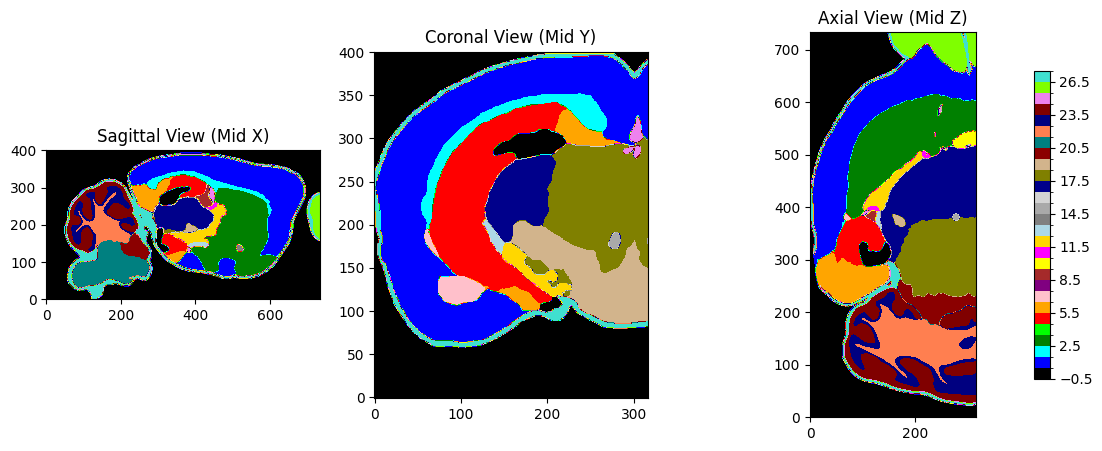

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2562_RCL5_left.nii.gz


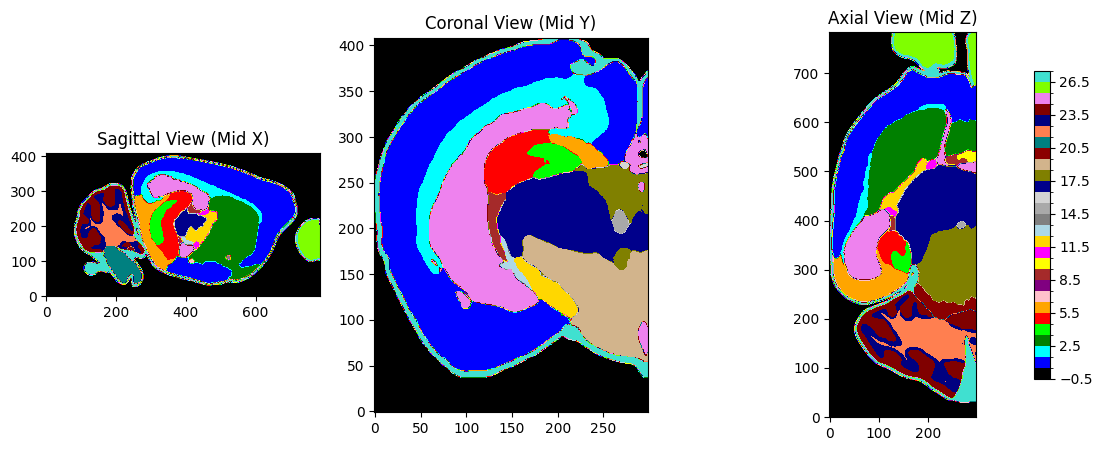

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2563_RCL5_left.nii.gz


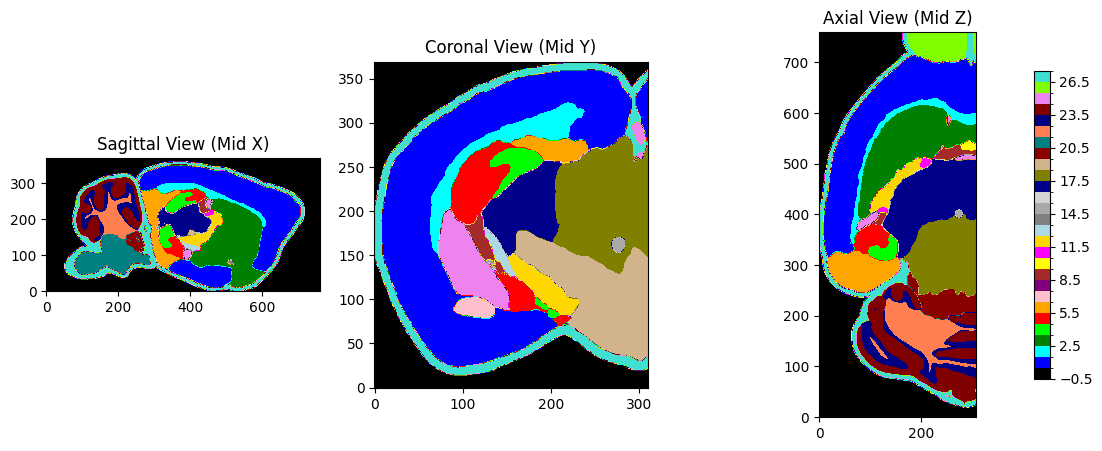

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2564_RCL5_left.nii.gz


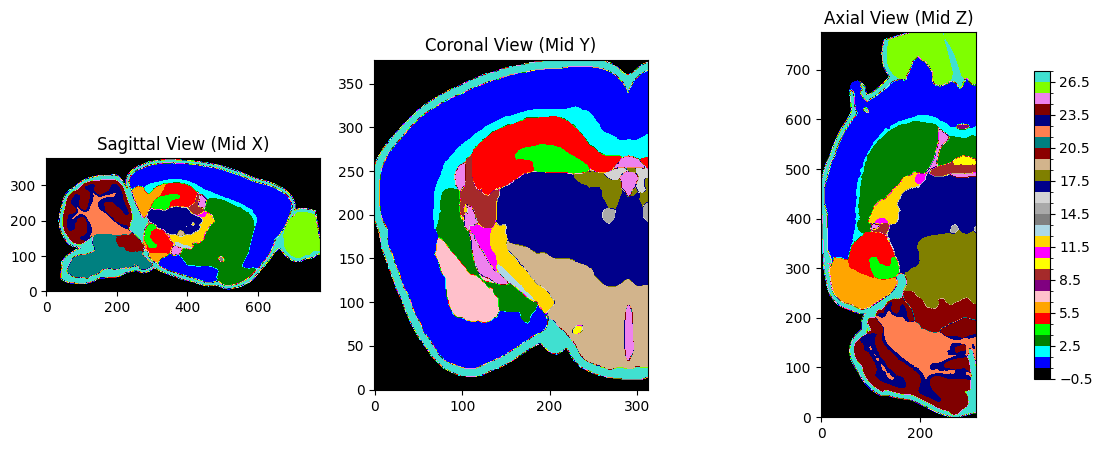

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2565_RCL5_left.nii.gz


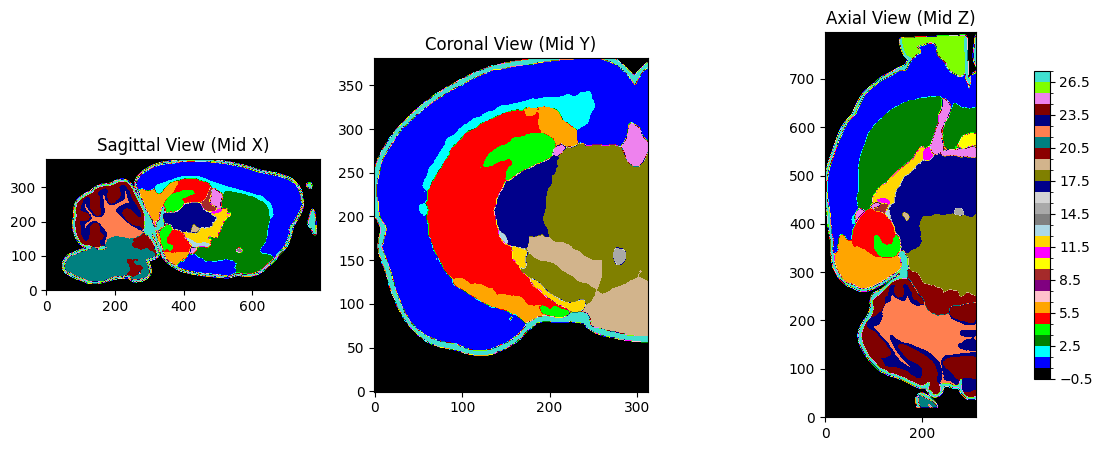

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4988_RCL5.nii.gz


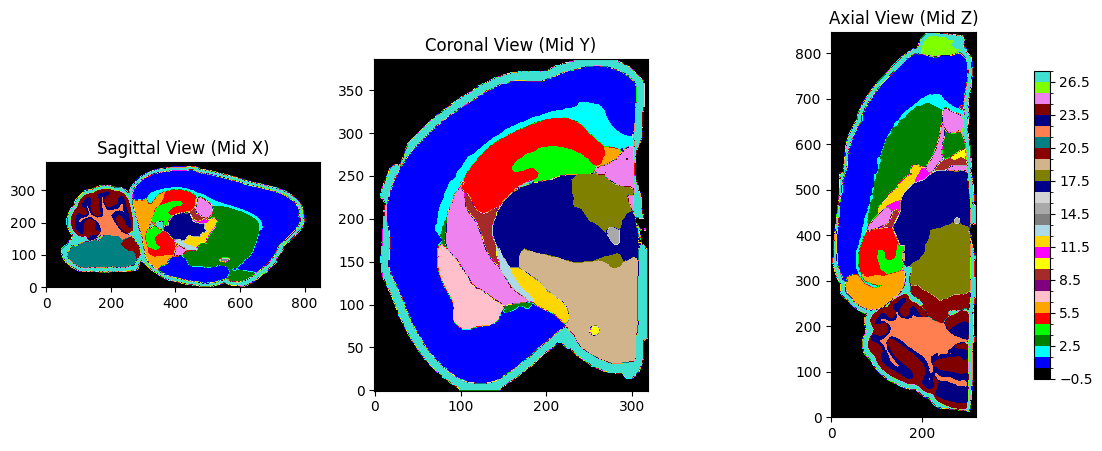

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4990_RCL5.nii.gz


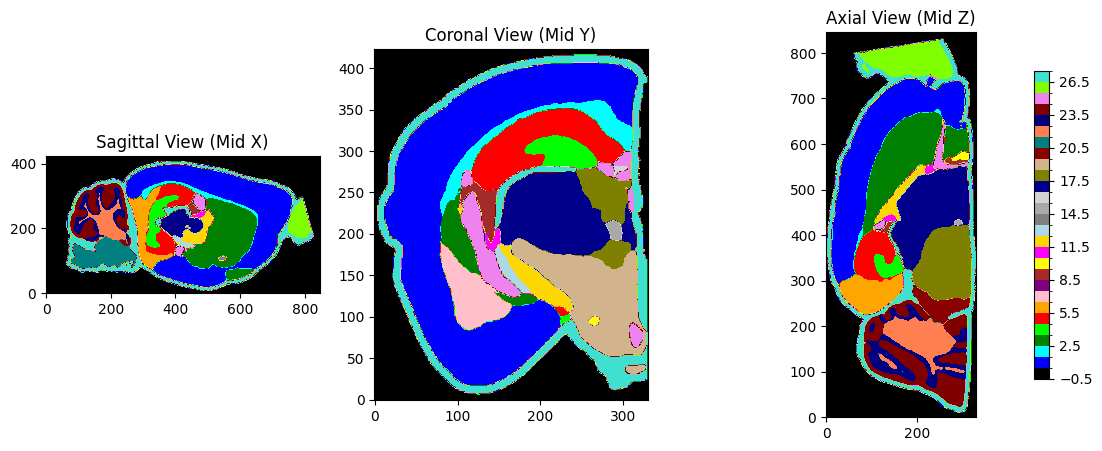

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4993_RCL5.nii.gz


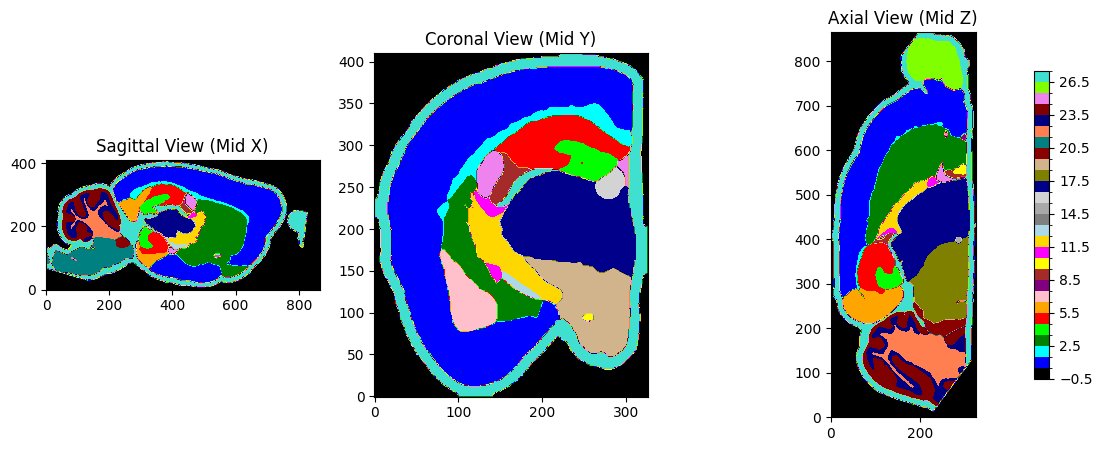

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4995_RCL5.nii.gz


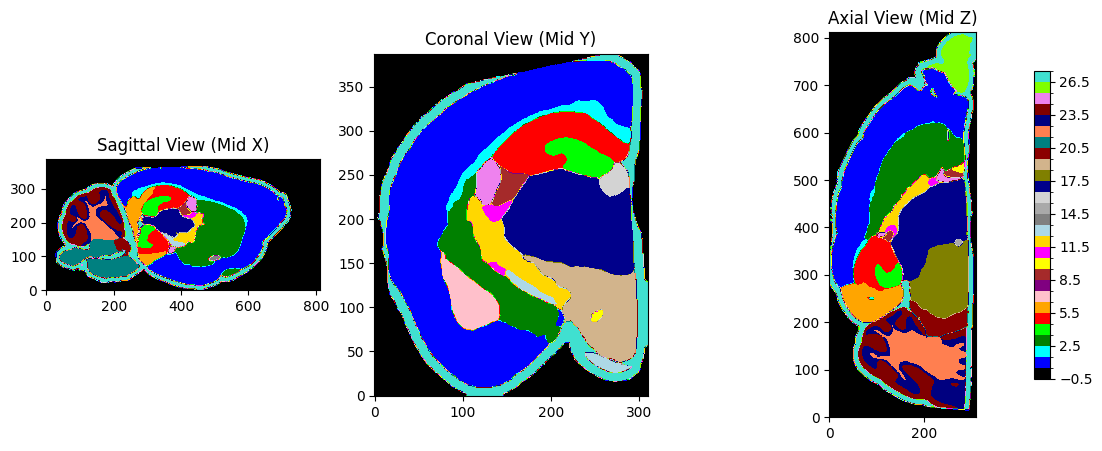

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4996_RCL5.nii.gz


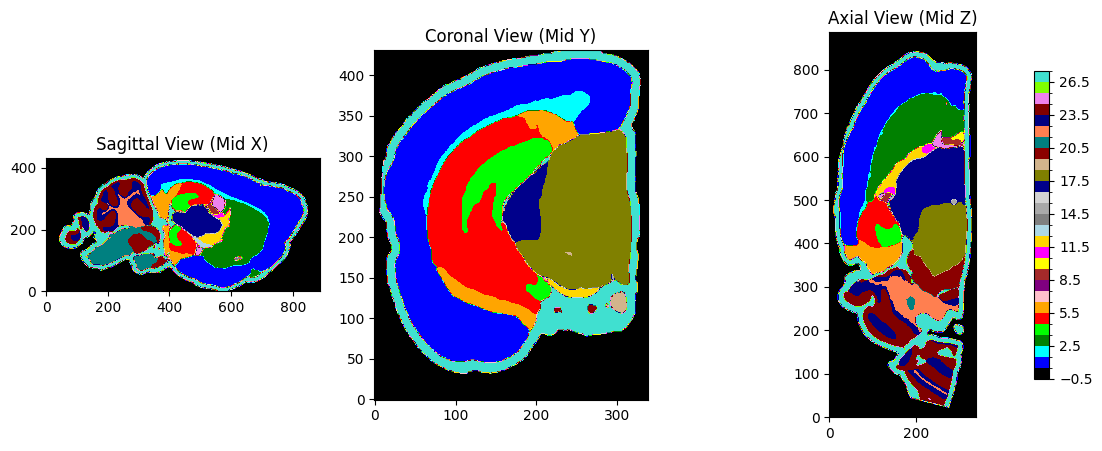

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG4997_RCL5.nii.gz


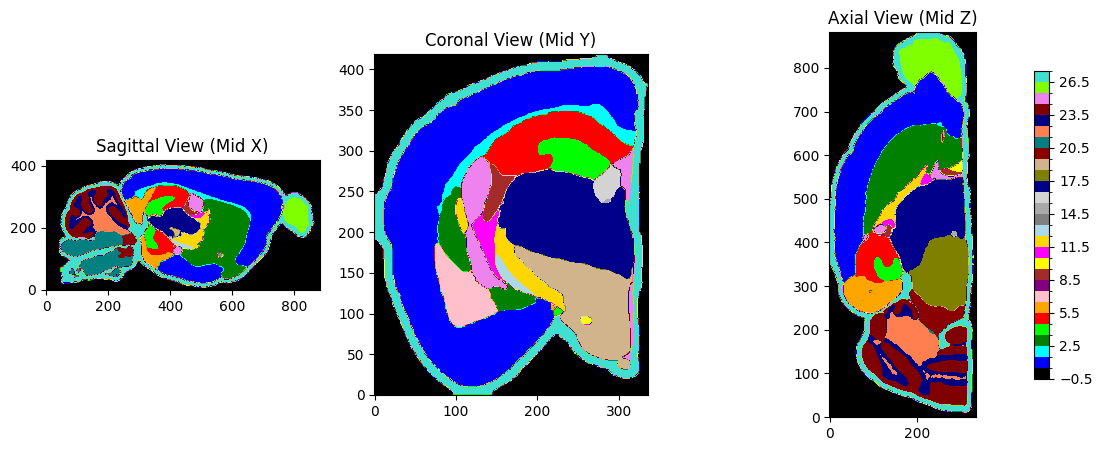

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG25610_RCL5_right.nii.gz


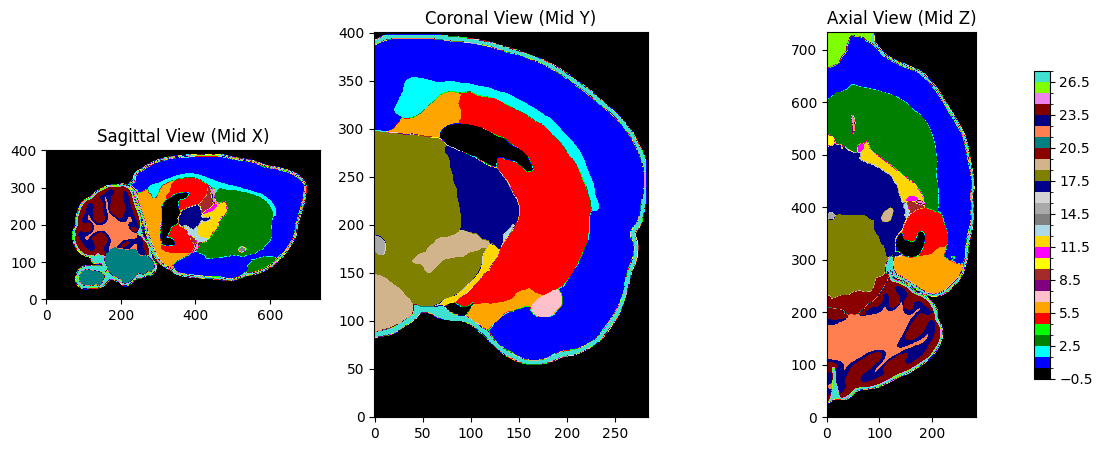

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG25620_RCL5_right.nii.gz


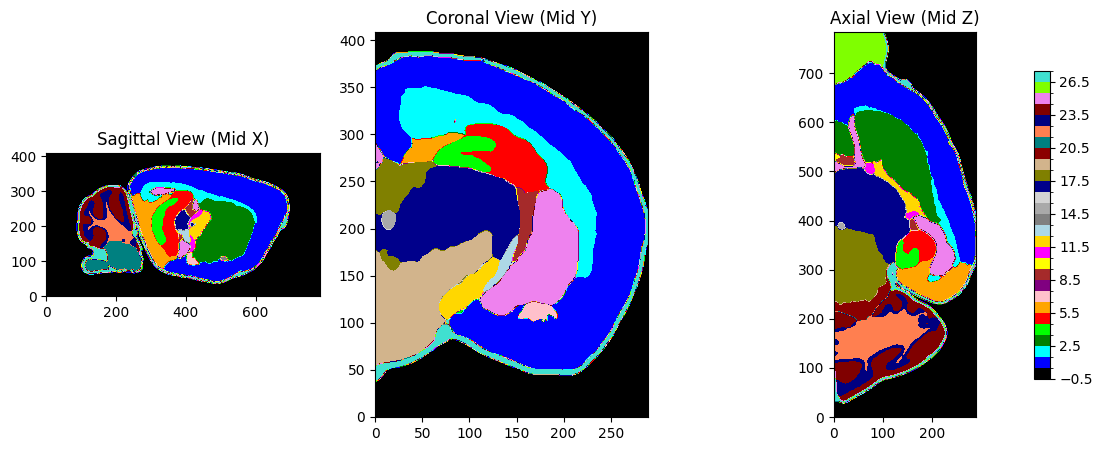

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG25630_RCL5_right.nii.gz


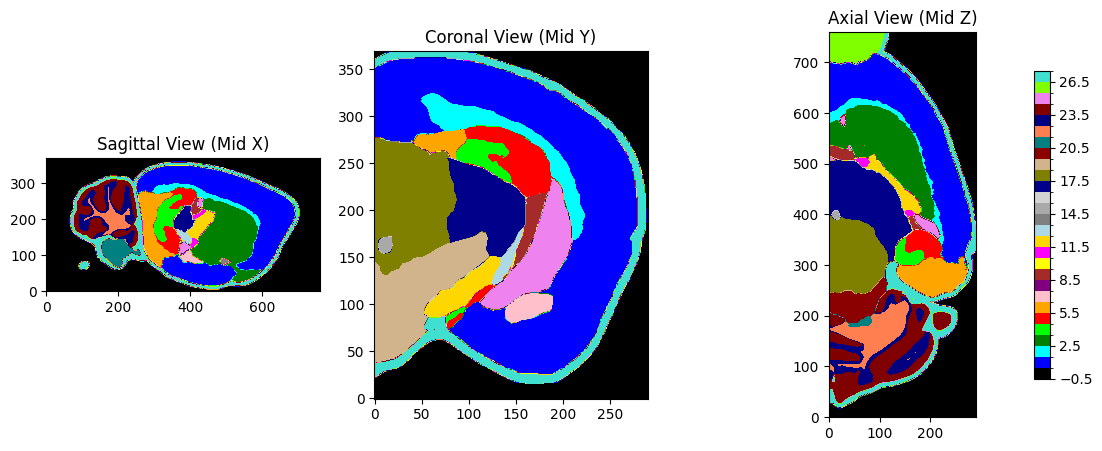

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG25640_RCL5_right.nii.gz


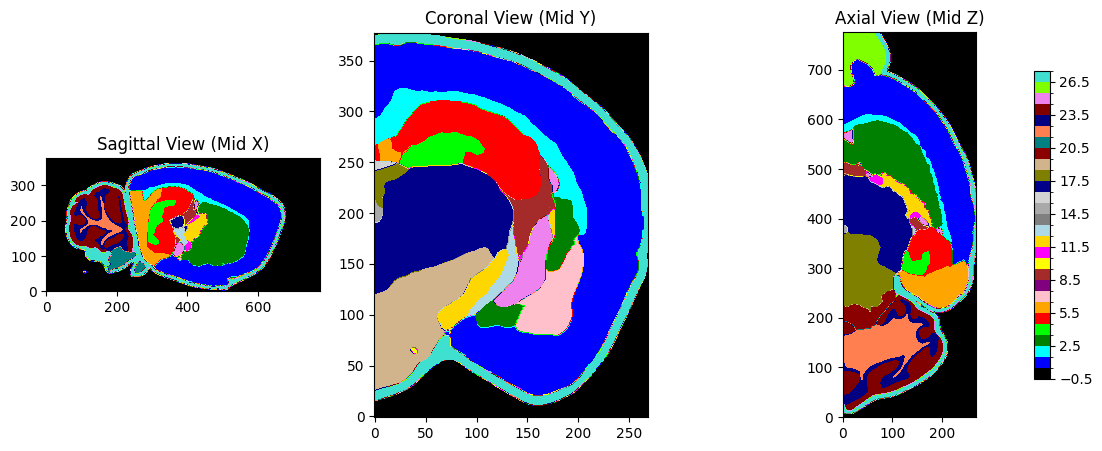

🔍 Visualizing: /beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG25650_RCL5_right.nii.gz


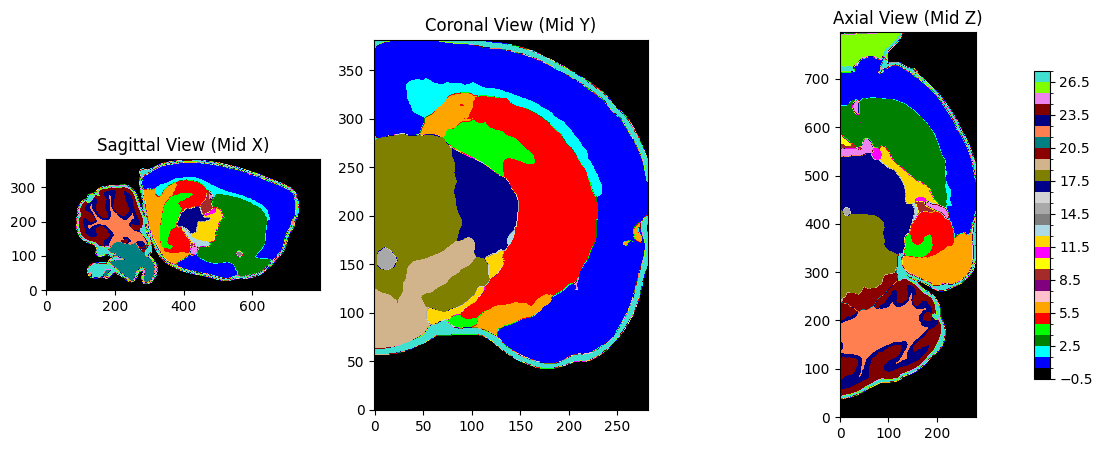

In [4]:
import glob

nifti_files = glob.glob(os.path.join(GT_TRAINING_DATASET_PATH, "*.nii.gz"))

for nifti_file in nifti_files:
    print(f"🔍 Visualizing: {nifti_file}")
    plot_nifti_slices(nifti_file)

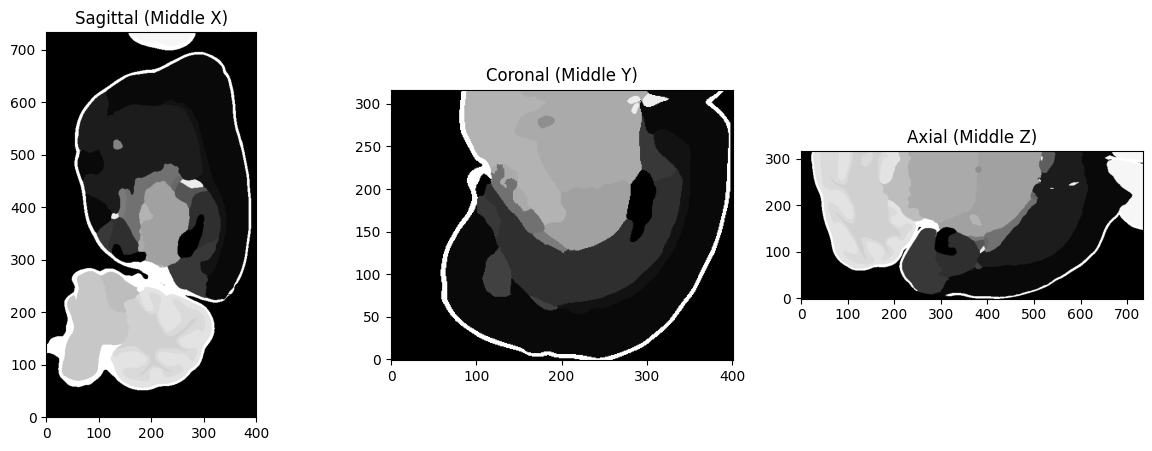

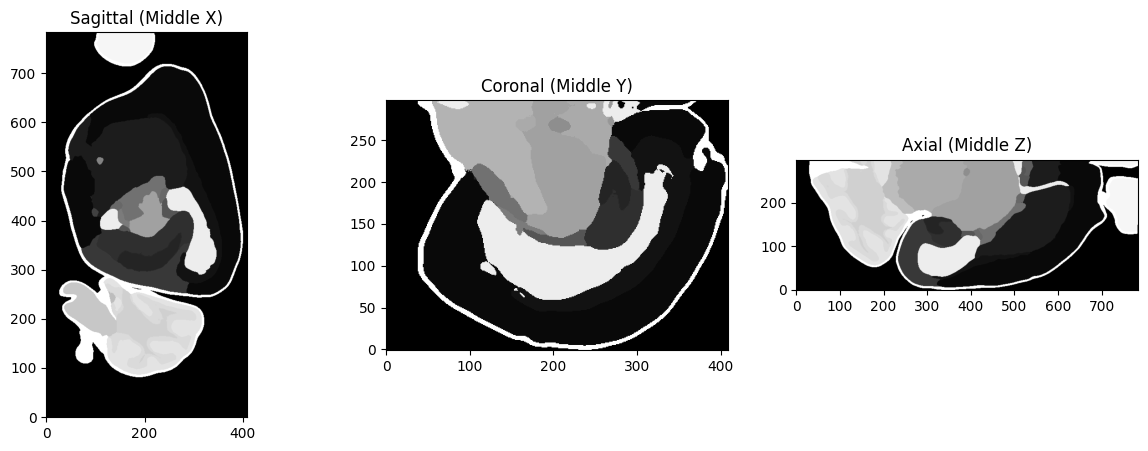

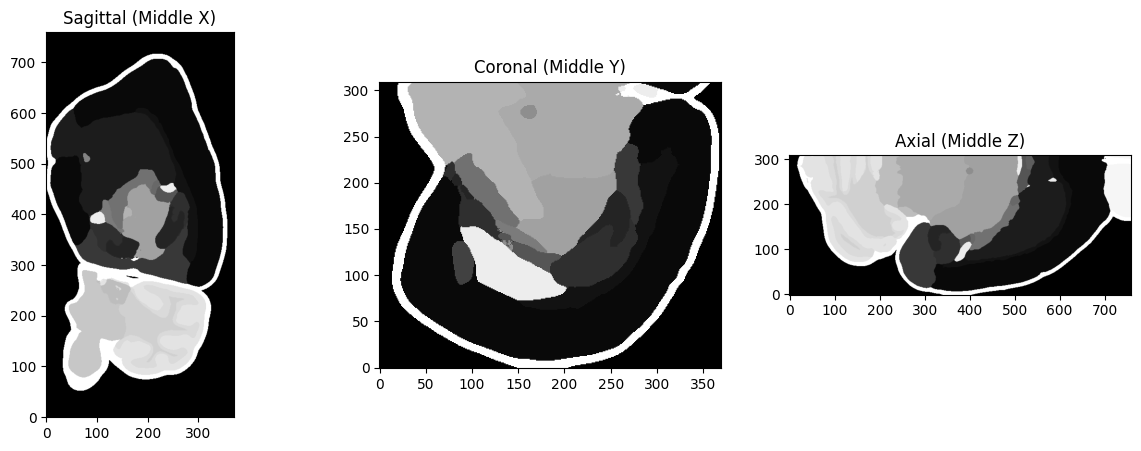

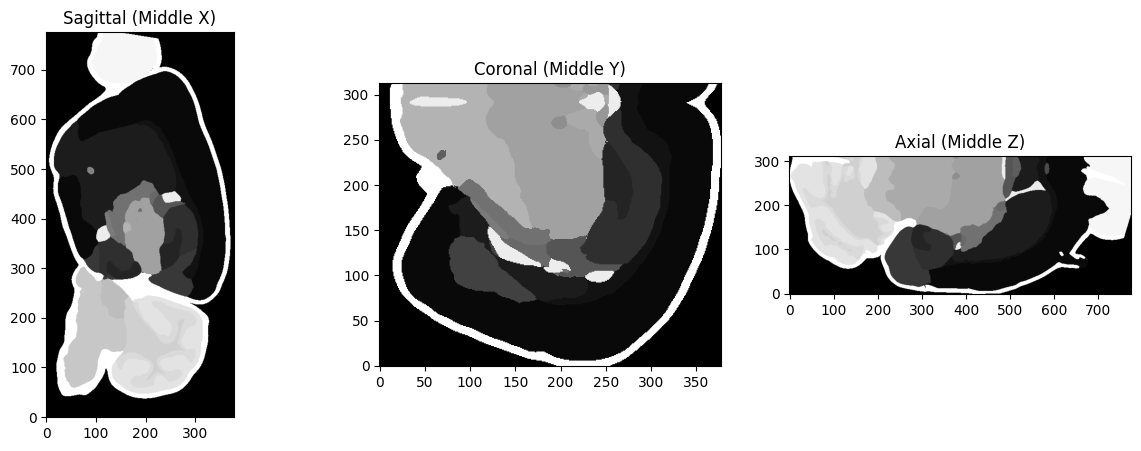

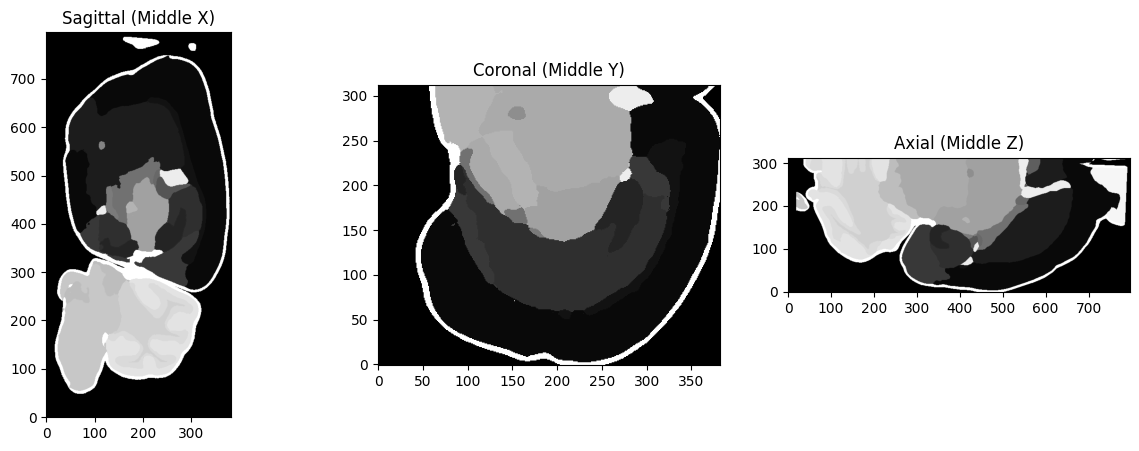

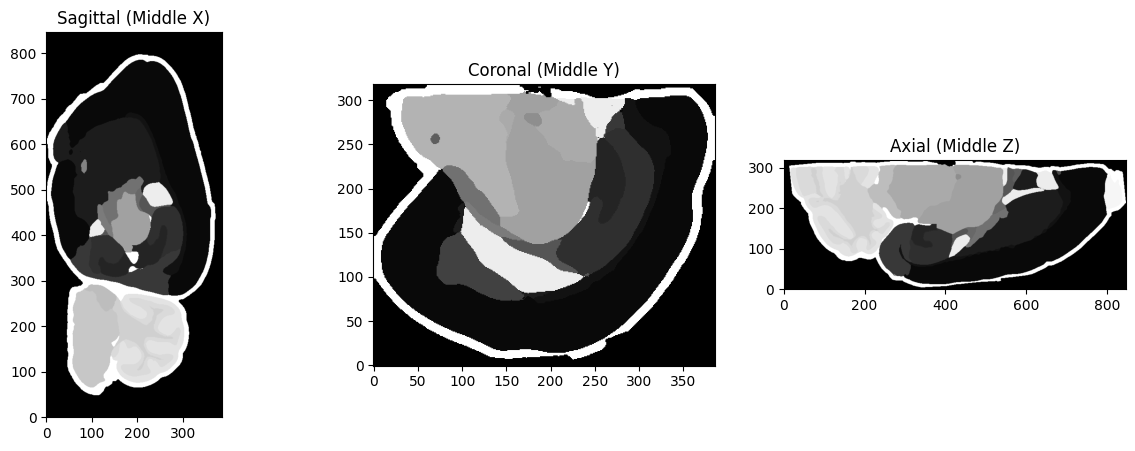

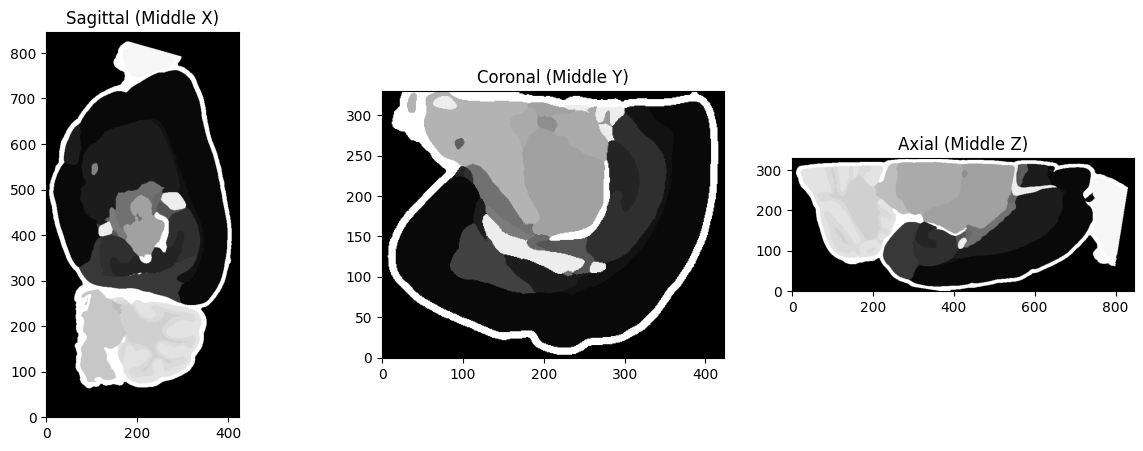

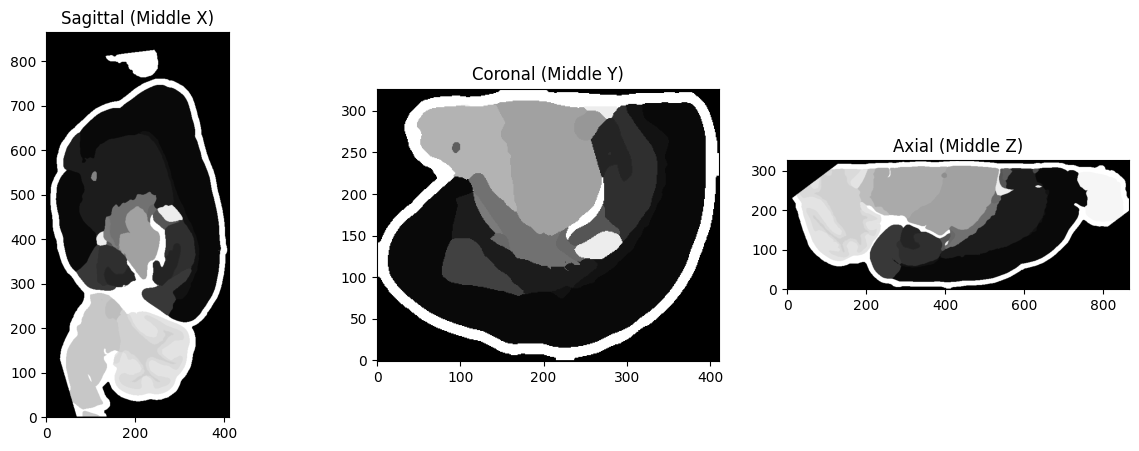

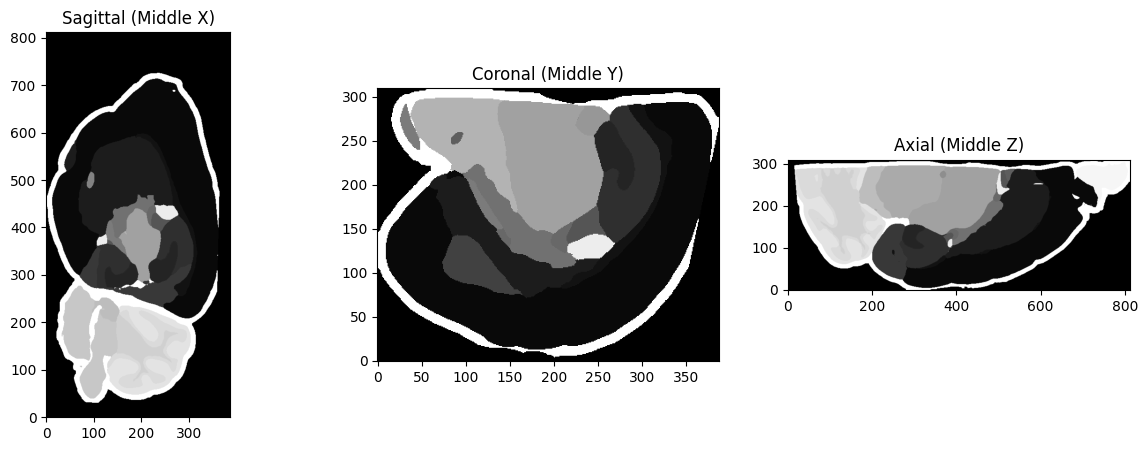

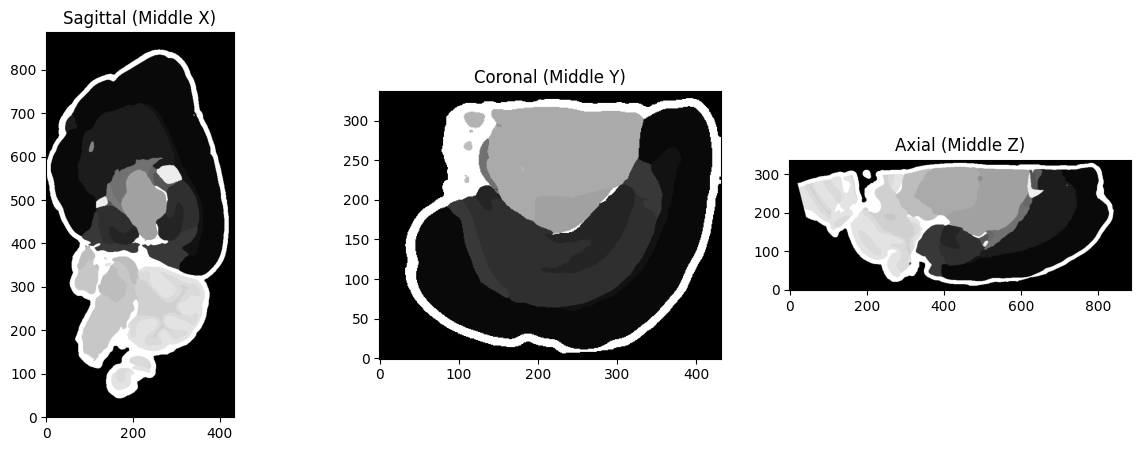

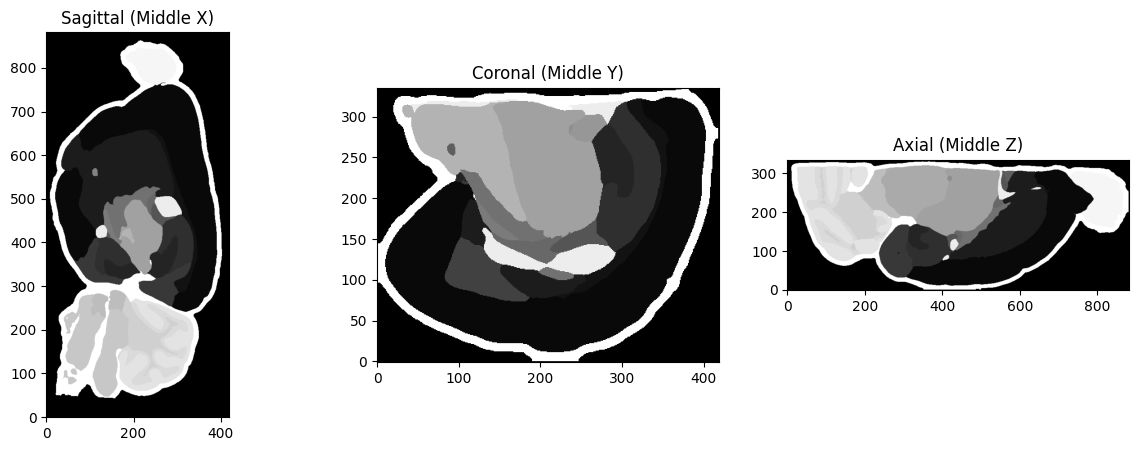

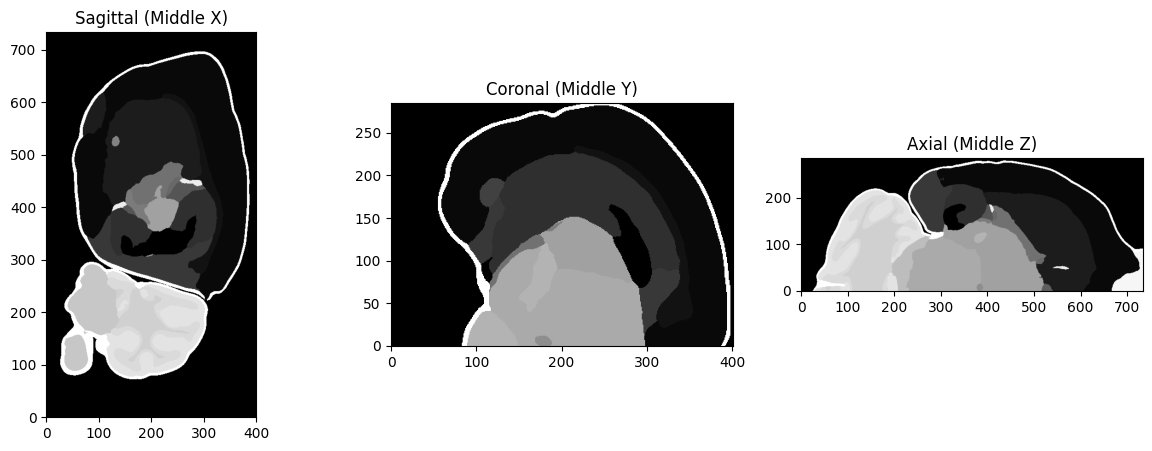

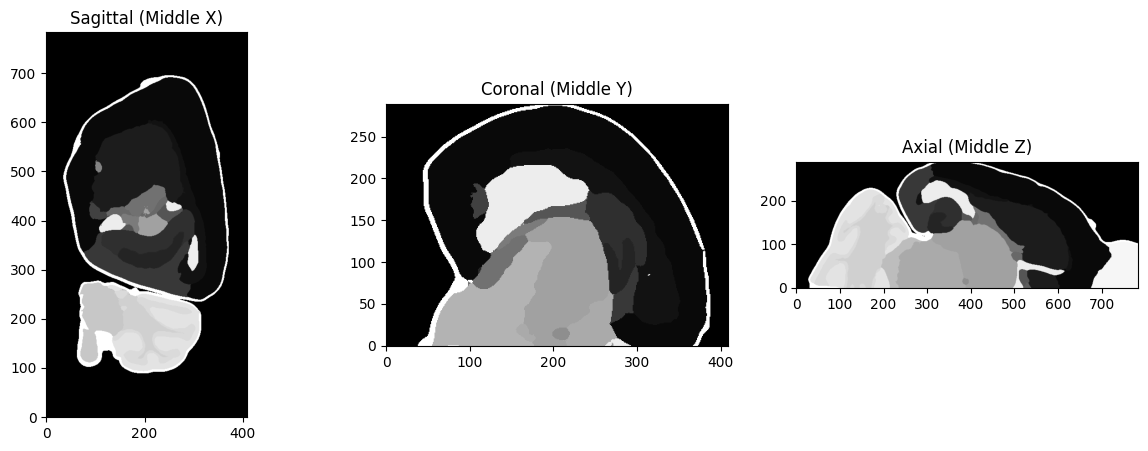

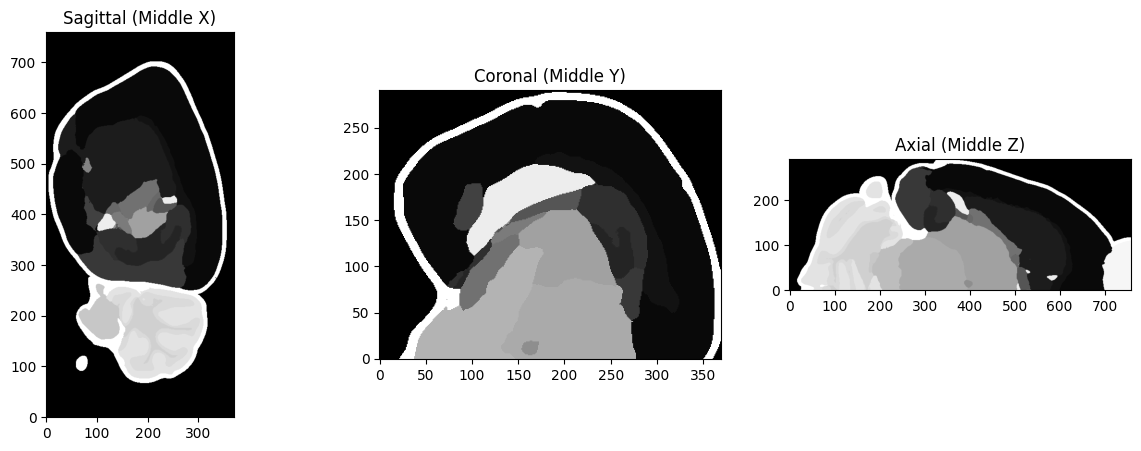

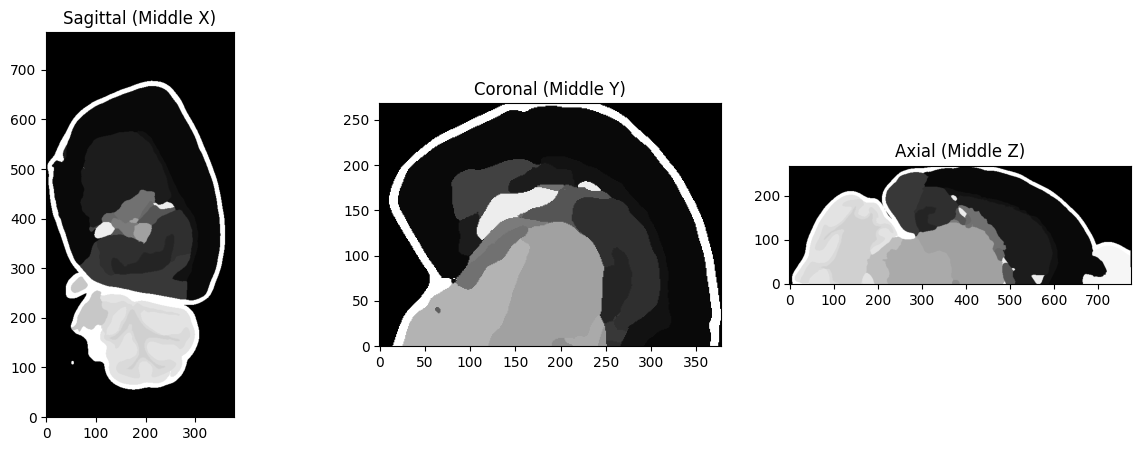

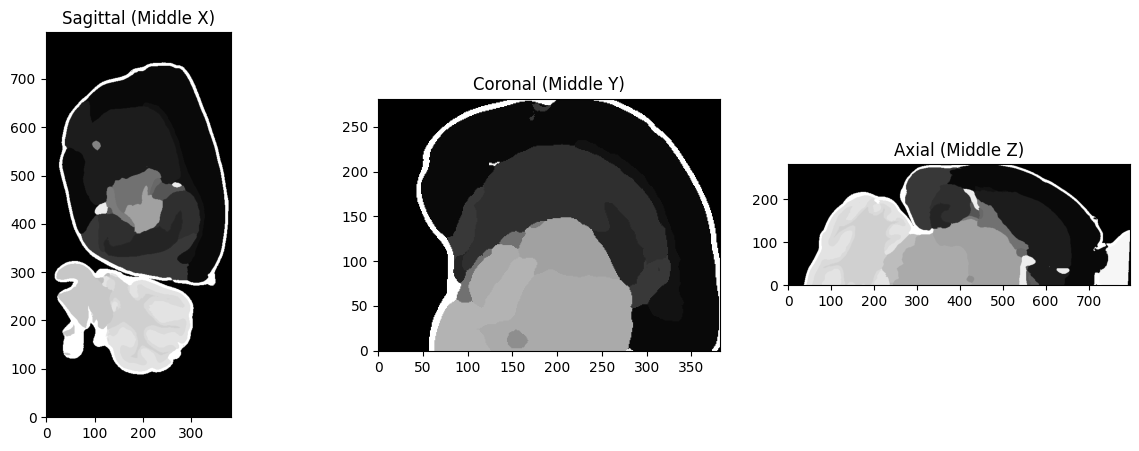

In [5]:
for nii_file in os.listdir(GT_TRAINING_DATASET_PATH):
    if nii_file.endswith(".nii.gz"):
        # Load the NIfTI file
        nii_path = os.path.join(GT_TRAINING_DATASET_PATH, nii_file)
        img = nib.load(nii_path)
        data = img.get_fdata()

        # Compute the middle slices
        mid_x = data.shape[0] // 2  # Middle sagittal
        mid_y = data.shape[1] // 2  # Middle coronal
        mid_z = data.shape[2] // 2  # Middle axial

        # Plot the slices
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(data[mid_x, :, :], cmap="gray", origin="lower")
        axes[0].set_title("Sagittal (Middle X)")

        axes[1].imshow(data[:, mid_y, :], cmap="gray", origin="lower")
        axes[1].set_title("Coronal (Middle Y)")

        axes[2].imshow(data[:, :, mid_z], cmap="gray", origin="lower")
        axes[2].set_title("Axial (Middle Z)")

        plt.show()

# Shape match of volume and labels 

In [9]:
# To check the shape match without saving

# Define paths
image_dir = TRAINING_DATASET_PATH
label_dir = GT_TRAINING_DATASET_PATH


# Get all image and label files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".nii.gz")])

# Extract base names before "_" (e.g., NG2561)
def extract_base_name(filename):
    match = re.match(r"(NG\d+)", filename)  # Match pattern like NG2561
    return match.group(1) if match else None

# Create a mapping of base names to filenames
image_dict = {extract_base_name(f): f for f in image_files}
label_dict = {extract_base_name(f): f for f in label_files}

# Check matching images and segmentations
for base_name in image_dict.keys():
    if base_name in label_dict:
        # Load image and segmentation
        img_path = os.path.join(image_dir, image_dict[base_name])
        seg_path = os.path.join(label_dir, label_dict[base_name])

        img = nib.load(img_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        # Print shapes
        print(f"Match Found: {base_name}")
        print("  Image shape:", img.shape)
        print("  Segmentation shape:", seg.shape)
        print("-" * 40)


Match Found: NG25610
  Image shape: (285, 734, 401)
  Segmentation shape: (285, 734, 401)
----------------------------------------
Match Found: NG2561
  Image shape: (317, 734, 401)
  Segmentation shape: (317, 734, 401)
----------------------------------------
Match Found: NG25620
  Image shape: (290, 784, 409)
  Segmentation shape: (290, 784, 409)
----------------------------------------
Match Found: NG2562
  Image shape: (299, 784, 409)
  Segmentation shape: (299, 784, 409)
----------------------------------------
Match Found: NG25630
  Image shape: (291, 760, 370)
  Segmentation shape: (291, 760, 370)
----------------------------------------
Match Found: NG2563
  Image shape: (310, 760, 370)
  Segmentation shape: (310, 760, 370)
----------------------------------------
Match Found: NG25640
  Image shape: (269, 776, 378)
  Segmentation shape: (269, 776, 378)
----------------------------------------
Match Found: NG2564
  Image shape: (313, 776, 378)
  Segmentation shape: (313, 776, 37

In [ ]:
# import nibabel as nib

# img = nib.load('dataset/nnUNet_raw_data/Dataset004_first/imagesTr/NG2561_RCL5_0000.nii.gz')
# seg = nib.load('dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2561_RCL5.nii.gz')


# print("Image shape:", img.shape)
# print("Segmentation shape:", seg.shape)

# print("Image voxel spacing:", img.header.get_zooms())
# print("Segmentation voxel spacing:", seg.header.get_zooms())

# print("Image affine:\n", img.affine)
# print("Segmentation affine:\n", seg.affine)


In [ ]:
# To save padded shapes

# Define paths
image_dir = TRAINING_DATASET_PATH
label_dir = GT_TRAINING_DATASET_PATH

# Get all image and label files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".nii.gz")])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(".nii.gz")])

# Extract base names before "_" (e.g., NG2561)
def extract_base_name(filename):
    match = re.match(r"(NG\d+)", filename)  # Match pattern like NG2561
    return match.group(1) if match else None

# Create a mapping of base names to filenames
image_dict = {extract_base_name(f): f for f in image_files}
label_dict = {extract_base_name(f): f for f in label_files}

def pad_to_match(image, segmentation):
    """
    Pads the smaller volume to match the shape of the larger volume.
    Assumes only the first dimension (depth) varies.
    """
    img_shape = np.array(image.shape)
    seg_shape = np.array(segmentation.shape)

    if np.array_equal(img_shape, seg_shape):
        return image, segmentation  # Already matching

    pad_width = [(0, 0), (0, 0), (0, 0)]  # Default (no padding)

    for i in range(3):  # Iterate over dimensions
        diff = seg_shape[i] - img_shape[i]
        if diff > 0:  # Image is smaller
            pad_width[i] = (0, diff)
        elif diff < 0:  # Segmentation is smaller
            pad_width[i] = (0, -diff)

    if img_shape[0] < seg_shape[0]:  # Image is smaller in depth
        image = np.pad(image, pad_width, mode='constant', constant_values=0)
    elif img_shape[0] > seg_shape[0]:  # Segmentation is smaller in depth
        segmentation = np.pad(segmentation, pad_width, mode='constant', constant_values=0)

    return image, segmentation

# Loop through matched images and segmentations
for base_name in image_dict.keys():
    if base_name in label_dict:
        img_path = os.path.join(image_dir, image_dict[base_name])
        seg_path = os.path.join(label_dir, label_dict[base_name])

        # Load files
        img_nii = nib.load(img_path)
        seg_nii = nib.load(seg_path)

        img = img_nii.get_fdata()
        seg = seg_nii.get_fdata()

        # Pad to match sizes
        img, seg = pad_to_match(img, seg)

        # Save the fixed files
        nib.save(nib.Nifti1Image(img, img_nii.affine, img_nii.header), img_path)
        nib.save(nib.Nifti1Image(seg, seg_nii.affine, seg_nii.header), seg_path)

        print(f"Fixed & Saved: {base_name}")
        print("  New Image shape:", img.shape)
        print("  New Segmentation shape:", seg.shape)
        print("-" * 40)


Fixed & Saved: NG2561
  New Image shape: (317, 734, 401)
  New Segmentation shape: (317, 734, 401)
----------------------------------------
Fixed & Saved: NG2562
  New Image shape: (299, 784, 409)
  New Segmentation shape: (299, 784, 409)
----------------------------------------
Fixed & Saved: NG2563
  New Image shape: (310, 760, 370)
  New Segmentation shape: (310, 760, 370)
----------------------------------------
Fixed & Saved: NG2564
  New Image shape: (313, 776, 378)
  New Segmentation shape: (313, 776, 378)
----------------------------------------
Fixed & Saved: NG2565
  New Image shape: (313, 797, 382)
  New Segmentation shape: (313, 797, 382)
----------------------------------------
Fixed & Saved: NG4988
  New Image shape: (319, 847, 387)
  New Segmentation shape: (319, 847, 387)
----------------------------------------
Fixed & Saved: NG4990
  New Image shape: (330, 846, 423)
  New Segmentation shape: (330, 846, 423)
----------------------------------------
Fixed & Saved: NG499

In [ ]:
# import nibabel as nib
# import numpy as np

# # Load segmentation
# seg = nib.load('dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2561_RCL5.nii.gz')
# seg_data = seg.get_fdata()

# # Pad with 13 slices (assuming missing slices at the top)
# padding = ((13, 0), (0, 0), (0, 0))  # Add 13 slices at the top
# padded_seg_data = np.pad(seg_data, padding, mode='constant', constant_values=0)

# # Save the fixed segmentation
# fixed_seg = nib.Nifti1Image(padded_seg_data, seg.affine, seg.header)
# nib.save(fixed_seg, 'dataset/nnUNet_raw_data/Dataset004_first/labelsTr/NG2561_RCL5.nii.gz')


# Preprocess

In [6]:
%env nnUNet_raw=$nnUNet_raw
%env nnUNet_preprocessed=$nnUNet_preprocessed
%env nnUNet_results=$nnUNet_results

env: nnUNet_raw=/beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data
env: nnUNet_preprocessed=/beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_preprocessed
env: nnUNet_results=/beegfs/data/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results


In [10]:
!nnUNetv2_plan_and_preprocess -d 4 --verify_dataset_integrity

Fingerprint extraction...
Dataset004_first
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100%|███████████████████████████████████████████| 16/16 [00:29<00:00,  1.81s/it]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Attempting to find 3d_lowres config. 
Current spacing: [1.03 1.03 1.03]. 
Current patch size: (112, 224, 80). 
Current median shape: [376.69902913 766.50485437 302.42718447]
Attempting to find 3d_lowres config. 
Current spacing: [1.0609 1.0609 1.060

# Load gcc 9.1

module load gcc/9.1.0
qsub -q gpu@webern49.u-bourgogne.fr /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/sub.sh